In [1]:
import os
import sys
import json
import copy
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image

import timm

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 

from src.utils import *

# setup seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

# load config
with open('src/config.json', 'r', encoding='utf8') as f:
    config_json = json.load(f)

data_path = config_json['data_path']
label_file = config_json['label_file']
landmark_file = config_json['landmark_file']

# check symptom information
symptoms_list = ['Red_lid', 'Red_conj','Swl_crncl', 'Swl_lid', 'Swl_conj']
symptoms_sort = ['Red_conj', 'Swl_conj','Swl_crncl', 'Red_lid', 'Swl_lid']
symptoms_rename = ['RC', 'CE', 'IC', 'RE', 'SE']

# settings
METRIC = 'WF1'
model_name_list = ['ResNet50', 'SE-Net50', 'SK-Net50', 'ResNeSt50', 'EfficientNet', 'ViT', 'Swin']
symptoms_mode_list = dict(zip(symptoms_list, [7,1,2,7,1]))

In [2]:
# load label
labels = pd.read_excel(os.path.join(data_path, label_file))
labels = labels.set_index('p_num')
labels = labels.drop(349)  # image error
labels = labels.replace(0.5,1)

# load label info        
labels_eye, labels_patient = load_labels(data_path, label_file)
landmarks_left, landmarks_right = load_landmark(data_path, landmark_file)

# run model training 
symptoms_left = ['_'.join([symptom, 'left', 'true']) for symptom in symptoms_list]
symptoms_right = ['_'.join([symptom, 'right', 'true']) for symptom in symptoms_list]

labels_left = labels_eye.apply(lambda s: s[symptoms_left].astype(int).tolist(), axis=1).to_dict()
labels_right = labels_eye.apply(lambda s: s[symptoms_right].astype(int).tolist(), axis=1).to_dict()

In [3]:
true_label_df = []
# for symptom in symptoms_list:
for symptom in symptoms_sort:
    true_label = labels_eye['_'.join([symptom, 'left', 'true'])].to_list() + labels_eye['_'.join([symptom, 'right', 'true'])].to_list()
    true_label_df.append(true_label)
    
    print(symptom, '\t{:0.3f} \t{:0.3f} \t{:0.3f}'.format(
          labels_eye['_'.join([symptom, 'left', 'true'])].mean(), labels_eye['_'.join([symptom, 'right', 'true'])].mean(),\
         (labels_eye['_'.join([symptom, 'left', 'true'])] + labels_eye['_'.join([symptom, 'right', 'true'])]).clip(0,1).mean()))

Red_conj 	0.363 	0.344 	0.419
Swl_conj 	0.086 	0.067 	0.105
Swl_crncl 	0.095 	0.098 	0.121
Red_lid 	0.290 	0.284 	0.336
Swl_lid 	0.703 	0.753 	0.833


In [4]:
symptoms_sort = ['Red_conj', 'Swl_conj','Swl_crncl', 'Red_lid', 'Swl_lid']
pd.DataFrame(true_label_df, index=symptoms_list).T.corr().loc[symptoms_sort, symptoms_sort]

,Red_conj,Swl_conj,Swl_crncl,Red_lid,Swl_lid
Red_conj,1.000000,0.138815,0.311782,0.308058,0.147768
Swl_conj,0.138815,1.000000,0.129243,0.122980,0.290707
Swl_crncl,0.311782,0.129243,1.000000,0.212904,0.133799
Red_lid,0.308058,0.122980,0.212904,1.000000,0.124856
Swl_lid,0.147768,0.290707,0.133799,0.124856,1.000000


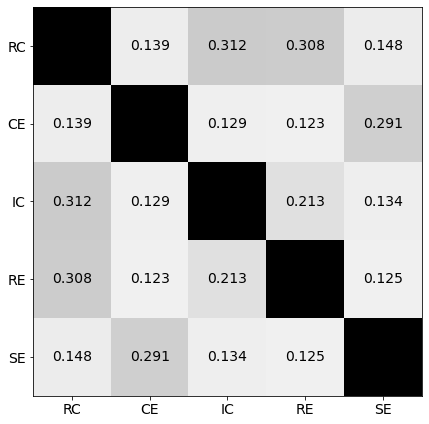

In [5]:
data = pd.DataFrame(true_label_df, index=symptoms_list).T.corr().loc[symptoms_sort, symptoms_sort]

plt.figure(figsize=(6,6))
plt.imshow(data, vmin=0, vmax=1, cmap='Greys')

for (j,i),label in np.ndenumerate(data.to_numpy()):
    plt.text(i,j,'{:0.3f}'.format(label),ha='center',va='center', fontsize=14)

plt.xticks(range(5), ['RC', 'CE', 'IC', 'RE', 'SE'], fontsize=14)
plt.yticks(range(5), ['RC', 'CE', 'IC', 'RE', 'SE'], fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# read splits
with open('src/cv_list', 'rb') as f:
    cv_list = pickle.load(f)

In [7]:
out_KNJ = []
out_JHK = []
out_LMJ = []

for k in tqdm(range(10)):
    cv_k = cv_list[k]
    pid_train = cv_k[1]
    
    pid_test = labels_patient.loc[cv_k[3].flatten()] 
    pid_test = pid_test.index
    img_test = [str(pid)+'_left' for pid in pid_test] + [str(pid)+'_right' for pid in pid_test]

    trues_all_list = []
    preds_all_list = []
    scores_all_list = []
    
    for i in range(5):
        symptom = symptoms_list[i]
        label_symptom = labels_patient[[symptom+'_patient']]
        
        labels_left = labels_eye['_'.join([symptom, 'left', 'true'])].to_dict()
        labels_right = labels_eye['_'.join([symptom, 'right', 'true'])].to_dict()        

        # get expert opinion
        c_names = [c for c in labels.columns if (symptom in c) & ('left' in c) & ('MG' not in c)]
        labels_expert = labels[c_names].copy()
        loc = 'left'
        labels_expert_left = dict(zip(labels.index, labels_expert.to_numpy()))

        c_names = [c for c in labels.columns if (symptom in c) & ('right' in c) & ('MG' not in c)]
        labels_expert = labels[c_names].copy()
        loc = 'right'
        labels_expert_right = dict(zip(labels.index, labels_expert.to_numpy()))

        true_label = labels.loc[pid_test]['_'.join([symptom, 'MG', 'left'])].to_list() + labels.loc[pid_test]['_'.join([symptom, 'MG', 'right'])].to_list()
        KNJ_label = labels.loc[pid_test]['_'.join([symptom, 'KNJ', 'left'])].to_list() + labels.loc[pid_test]['_'.join([symptom, 'KNJ', 'right'])].to_list()
        JHK_label = labels.loc[pid_test]['_'.join([symptom, 'JHK', 'left'])].to_list() + labels.loc[pid_test]['_'.join([symptom, 'JHK', 'right'])].to_list()
        LMJ_label = labels.loc[pid_test]['_'.join([symptom, 'LMJ', 'left'])].to_list() + labels.loc[pid_test]['_'.join([symptom, 'LMJ', 'right'])].to_list()
        
        avg_metrics = get_metrics(true_label, KNJ_label)
        out = [symptom, k, *avg_metrics, None]
        out_KNJ.append(out)

        avg_metrics = get_metrics(true_label, JHK_label)
        out = [symptom, k, *avg_metrics, None]
        out_JHK.append(out)

        avg_metrics = get_metrics(true_label, LMJ_label)
        out = [symptom, k, *avg_metrics, None]
        out_LMJ.append(out)        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.51it/s]


In [8]:
out_all_KNJ = pd.DataFrame(out_KNJ, columns=['symptom', 'k', 'Accuracy', 'Precision', 'Recall', 'F1', 'sensitivity', 'specificity', 'BAC', 'WF1', 'AUC'])
out_all_JHK = pd.DataFrame(out_JHK, columns=['symptom', 'k', 'Accuracy', 'Precision', 'Recall', 'F1', 'sensitivity', 'specificity', 'BAC', 'WF1', 'AUC'])
out_all_LMJ = pd.DataFrame(out_LMJ, columns=['symptom', 'k', 'Accuracy', 'Precision', 'Recall', 'F1', 'sensitivity', 'specificity', 'BAC', 'WF1', 'AUC'])

In [9]:
out_all_KNJ['method'] = 'A'
out_all_JHK['method'] = 'B'
out_all_LMJ['method'] = 'C'

In [10]:
# doctor performance
out_all_doctor = pd.concat([out_all_KNJ, out_all_JHK, out_all_LMJ], axis=0).reset_index()

In [11]:
# svm performance
svm_results = pd.read_csv('experiments/svm_result.csv', index_col=0)
svm_results['method'] = 'svm'

Using Domain Knowledge

In [12]:
results_all = []
for model in model_name_list:
    for symptom in symptoms_list:
        mode = symptoms_mode_list[symptom]
        for k in range(10):
            try:
                with open('experiments/binary/{}/{}/{}_{}'.format(model, symptom, mode, k), 'rb') as f:
                    metrics = pickle.load(f)
                metrics_df = pd.DataFrame(metrics, columns=['symptom', 'k', 'kf', 'Accuracy', 'Precision', 'Recall', 'F1', 'sensitivity', 'specificity', 'BAC', 'WF1', 'AUC'])
                metrics_df['setting'] = 'domain'
                metrics_df['method'] = model
                metrics_df['mode'] = mode
                metrics_df = metrics_df.sort_values(METRIC, ascending=False).drop_duplicates(['symptom','k'])
                results_all.append(metrics_df)
            except:
                print('{}/{}/{}_{}'.format(model, symptom, mode, k))
                continue
            
results_combined = pd.concat(results_all, axis=0).reset_index()

In [13]:
metric_mean = results_combined.fillna('None').groupby(['method', 'setting']).mean()[[METRIC]]
metric_mean['upper'] = metric_mean[METRIC] + 1.96 / np.sqrt(10) * results_combined.fillna('None').groupby(['method', 'setting']).std()[METRIC]
metric_mean['lower'] = metric_mean[METRIC] - 1.96 / np.sqrt(10) * results_combined.fillna('None').groupby(['method', 'setting']).std()[METRIC]
metric_mean.loc[model_name_list]

,,WF1,upper,lower
method,setting,,,
ResNet50,domain,0.723008,0.810870,0.635147
SE-Net50,domain,0.719430,0.799731,0.639129
SK-Net50,domain,0.731922,0.813104,0.650739
ResNeSt50,domain,0.729139,0.813132,0.645145
EfficientNet,domain,0.753971,0.823918,0.684023
ViT,domain,0.717002,0.807952,0.626051
Swin,domain,0.660641,0.787393,0.533889


In [14]:
results_pivot = results_combined.fillna('None').groupby(['symptom', 'method', 'setting']).mean()

In [15]:
results_pivot = pd.pivot_table(results_pivot, METRIC, ['method', 'setting'], 'symptom', 'mean').loc[model_name_list, symptoms_sort]
results_pivot['average'] = results_pivot.mean(axis=1)
results_pivot

,symptom,Red_conj,Swl_conj,Swl_crncl,Red_lid,Swl_lid,average
method,setting,,,,,,
ResNet50,domain,0.621620,0.890811,0.884274,0.648333,0.570004,0.723008
SE-Net50,domain,0.674981,0.864523,0.850618,0.666173,0.540854,0.719430
SK-Net50,domain,0.648893,0.888595,0.869628,0.685230,0.567262,0.731922
ResNeSt50,domain,0.652481,0.886254,0.872544,0.670332,0.564082,0.729139
EfficientNet,domain,0.665434,0.890514,0.878065,0.711175,0.624665,0.753971
ViT,domain,0.579202,0.877774,0.889331,0.670852,0.567850,0.717002
Swin,domain,0.419716,0.887854,0.874386,0.602791,0.518459,0.660641


TAOD-Net backbone test

In [16]:
results_all = []
for model in model_name_list:
    for mode in [0,1,2,7]:
        for k in range(10):
            try:
                with open('experiments/ablation/{}/{}_{}'.format(model,mode,k), 'rb') as f:
                    out = pickle.load(f)
            except:
                print('experiments/ablation/{}/{}_{}'.format(model,mode,k))
                continue

            results = []
            for val in out:
                _k = val[0]
                _kf = val[1]
                _true_val = val[2]
                _pred_val = val[3]
                _score_val = val[4]

                metrics_list = []
                for i in range(5):
                    metrics = get_metrics(_true_val[:,i], _pred_val[:,i])
                    auc_score = roc_auc_score(_true_val[:,i], _score_val[:,i])
                    metrics_list.append([symptoms_list[i], *metrics, auc_score])

                metrics_df = pd.DataFrame(metrics_list, columns=['symptom', 'Accuracy', 'Precision', 'Recall', 'F1', 'sensitivity', 'specificity', 'BAC', 'WF1', 'AUC'])
                metrics_df['k'] = _k
                metrics_df['kf'] = _kf
                metrics_df['setting'] = 'multi'
                metrics_df['method'] = model
                metrics_df['mode'] = mode

                results.append(metrics_df)

            results_kf = pd.concat(results, axis=0).sort_values(METRIC, ascending=False).drop_duplicates(['symptom','k'])
            results_all.append(results_kf)

In [17]:
results_TAOD = pd.concat(results_all, axis=0).reset_index()

In [18]:
results_all = []
for symptom in symptoms_list:
    results_all.append(results_TAOD.loc[(results_TAOD['symptom']==symptom)&(results_TAOD['mode']==symptoms_mode_list[symptom])])

In [19]:
results_combined = pd.concat(results_all, axis=0)

In [20]:
metric_mean = results_combined.fillna('None').groupby(['method', 'setting']).mean()[[METRIC]]
metric_mean['upper'] = metric_mean[METRIC] + 1.96 / np.sqrt(10) * results_combined.fillna('None').groupby(['method', 'setting']).std()[METRIC]
metric_mean['lower'] = metric_mean[METRIC] - 1.96 / np.sqrt(10) * results_combined.fillna('None').groupby(['method', 'setting']).std()[METRIC]
metric_mean.loc[model_name_list]

,,WF1,upper,lower
method,setting,,,
ResNet50,multi,0.753171,0.831481,0.674862
SE-Net50,multi,0.753966,0.833784,0.674148
SK-Net50,multi,0.738954,0.818949,0.658960
ResNeSt50,multi,0.758705,0.836179,0.681231
EfficientNet,multi,0.748934,0.828117,0.669751
ViT,multi,0.795406,0.863199,0.727613
Swin,multi,0.777210,0.848832,0.705589


In [21]:
results_pivot = results_combined.fillna('None').groupby(['symptom', 'method', 'setting']).mean()

In [22]:
results_pivot = pd.pivot_table(results_pivot, METRIC, ['method', 'setting'], 'symptom', 'mean').loc[model_name_list, symptoms_sort]
results_pivot['average'] = results_pivot.mean(axis=1)
results_pivot

,symptom,Red_conj,Swl_conj,Swl_crncl,Red_lid,Swl_lid,average
method,setting,,,,,,
ResNet50,multi,0.676921,0.905678,0.895057,0.690976,0.597225,0.753171
SE-Net50,multi,0.684621,0.908513,0.899475,0.683499,0.593724,0.753966
SK-Net50,multi,0.642389,0.899768,0.880478,0.681177,0.590960,0.738954
ResNeSt50,multi,0.688742,0.908383,0.896429,0.705167,0.594804,0.758705
EfficientNet,multi,0.665401,0.906032,0.889401,0.691454,0.592381,0.748934
ViT,multi,0.709423,0.918477,0.903558,0.802665,0.642907,0.795406
Swin,multi,0.702142,0.914090,0.903043,0.741954,0.624824,0.777210
